# Comparing KNN and an OLS Regression Models  
For this challenge, we will build a KNN Regression and an OLS regression and compare the two. We will be using the [
Facebook metrics Dataset](http://archive.ics.uci.edu/ml/datasets/Facebook+metrics) collected by SÃ©rgio Moro, Paulo Rita and Bernardo Vala. This dataset contains 19 attributes related to Facebook's page of a renowned cosmetics brand. We will be predicting the numbers of total interactions a post will get. 

In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn import neighbors

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import mse, rmse

In [2]:
df = pd.read_csv('dataset_Facebook.csv',delimiter=';')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
df.head()

,page_total_likes,type,category,post_month,post_weekday,post_hour,paid,lifetime_post_total_reach,lifetime_post_total_impressions,lifetime_engaged_users,lifetime_post_consumers,lifetime_post_consumptions,lifetime_post_impressions_by_people_who_have_liked_your_page,lifetime_post_reach_by_people_who_like_your_page,lifetime_people_who_have_liked_your_page_and_engaged_with_your_post,comment,like,share,total_interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
page_total_likes                                                       500 non-null int64
type                                                                   500 non-null object
category                                                               500 non-null int64
post_month                                                             500 non-null int64
post_weekday                                                           500 non-null int64
post_hour                                                              500 non-null int64
paid                                                                   499 non-null float64
lifetime_post_total_reach                                              500 non-null int64
lifetime_post_total_impressions                                        500 non-null int64
lifetime_engaged_users                                                 500 non-nul

In [4]:
# Convert to string 

convert_type = ['type','category','post_month','post_weekday','post_hour','paid','lifetime_post_impressions_by_people_who_have_liked_your_page']

df[convert_type] = df[convert_type].astype(str)

In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [6]:
# Check for missing values 

missing_values_table(df)

Your selected dataframe has 19 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
share,4,0.8
like,1,0.2


It looks like there are a couple of missing values in columns like and share. We'll fill in those missing values with the mode. 

In [7]:
# Imputation by mode
df2 = df.copy()

df2 = df.fillna(df.mode().iloc[0])

In [8]:
# Check for null values

df2.isnull().sum()

page_total_likes                                                       0
type                                                                   0
category                                                               0
post_month                                                             0
post_weekday                                                           0
post_hour                                                              0
paid                                                                   0
lifetime_post_total_reach                                              0
lifetime_post_total_impressions                                        0
lifetime_engaged_users                                                 0
lifetime_post_consumers                                                0
lifetime_post_consumptions                                             0
lifetime_post_impressions_by_people_who_have_liked_your_page           0
lifetime_post_reach_by_people_who_like_your_page   

Alright. Doesn't look like we have anymore missing values. 
Let's get some summary statistics on the dataset. 


In [9]:
df2.describe()

,page_total_likes,lifetime_post_total_reach,lifetime_post_total_impressions,lifetime_engaged_users,lifetime_post_consumers,lifetime_post_consumptions,lifetime_post_reach_by_people_who_like_your_page,lifetime_people_who_have_liked_your_page_and_engaged_with_your_post,comment,like,share,total_interactions
count,500.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,123194.176000,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,6585.488000,609.986000,7.48200,177.786000,27.152000,212.120000
std,16272.813214,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,7682.009405,612.725618,21.18091,323.094315,42.461215,380.233118
min,81370.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000
25%,112676.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,2181.500000,291.000000,1.00000,56.750000,10.000000,71.000000
50%,129600.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000
75%,136393.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,7989.000000,656.250000,7.00000,187.250000,32.000000,228.500000
max,139441.000000,180480.00000,1.110282e+06,11452.000000,11328.000000,19779.000000,51456.000000,4376.000000,372.00000,5172.000000,790.000000,6334.000000


In [10]:
df2.describe(include=['object'])

,type,category,post_month,post_weekday,post_hour,paid,lifetime_post_impressions_by_people_who_have_liked_your_page
count,500,500,500,500,500,500,500
unique,4,3,12,7,22,3,491
top,Photo,1,10,7,3,0.0,1210
freq,426,215,60,82,105,360,2


This dataset contains 500 rows of data.  It seems that the user posted mainly during night time on Sundays. 

In [11]:
df2.corr()

,page_total_likes,lifetime_post_total_reach,lifetime_post_total_impressions,lifetime_engaged_users,lifetime_post_consumers,lifetime_post_consumptions,lifetime_post_reach_by_people_who_like_your_page,lifetime_people_who_have_liked_your_page_and_engaged_with_your_post,comment,like,share,total_interactions
page_total_likes,1.000000,-0.083245,-0.102540,-0.111922,-0.149129,-0.128240,-0.060516,0.033699,0.031891,0.052823,-0.007003,0.045231
lifetime_post_total_reach,-0.083245,1.000000,0.694926,0.570629,0.477908,0.324362,0.743053,0.400756,0.427155,0.545258,0.457044,0.538597
lifetime_post_total_impressions,-0.102540,0.694926,1.000000,0.368553,0.315201,0.226081,0.651933,0.323843,0.316612,0.345203,0.287527,0.343358
lifetime_engaged_users,-0.111922,0.570629,0.368553,1.000000,0.968213,0.676840,0.612080,0.839279,0.505806,0.569515,0.531825,0.572159
lifetime_post_consumers,-0.149129,0.477908,0.315201,0.968213,1.000000,0.706666,0.503847,0.813510,0.334621,0.349298,0.344066,0.354502
lifetime_post_consumptions,-0.128240,0.324362,0.226081,0.676840,0.706666,1.000000,0.355389,0.577262,0.261195,0.235848,0.202502,0.238082
lifetime_post_reach_by_people_who_like_your_page,-0.060516,0.743053,0.651933,0.612080,0.503847,0.355389,1.000000,0.648701,0.472351,0.631515,0.487352,0.617929
lifetime_people_who_have_liked_your_page_and_engaged_with_your_post,0.033699,0.400756,0.323843,0.839279,0.813510,0.577262,0.648701,1.000000,0.425945,0.493107,0.440159,0.492570
comment,0.031891,0.427155,0.316612,0.505806,0.334621,0.261195,0.472351,0.425945,1.000000,0.837889,0.868461,0.864944
like,0.052823,0.545258,0.345203,0.569515,0.349298,0.235848,0.631515,0.493107,0.837889,1.000000,0.904039,0.997609


The most correlated variables to total interactions are like, share, and comment. However, these variables show colinarity among each other. We will run PCA on these variables to create a single feature to account for the variance of the three variables.

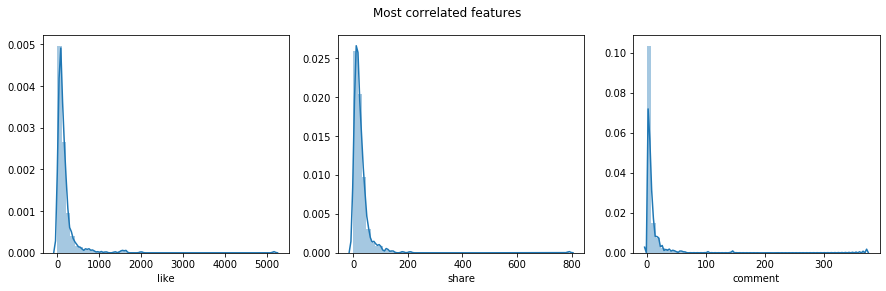

In [12]:
plt.figure(figsize=(15,4))
plt.suptitle('Most correlated features')

plt.subplot(1,3,1)
sns.distplot(df2.like)

plt.subplot(1,3,2)
sns.distplot(df2.share)

plt.subplot(1,3,3)
sns.distplot(df2.comment)
plt.show()

All three of these variables are right skewed. Let's remove values outside of 3 standard deviations and replace with the threshold value before performing PCA. 

In [13]:
# Function to detect extreme values and replace with threshold value

def outlier_table(df):
    for column in df.select_dtypes(['int64', 'float64']).columns:
        if df[column].quantile(.997)<df[column].max():
            threshold = df[column].quantile(.997)
            df[column] = np.where(df[column] > threshold, int(round(threshold)),df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        else:
            pass
    return df
            

In [14]:
df2 = outlier_table(df2)

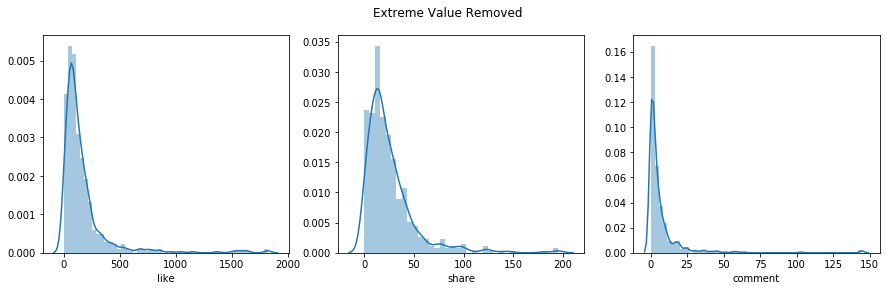

In [15]:
plt.figure(figsize=(15,4))
plt.suptitle('Extreme Value Removed')

plt.subplot(1,3,1)
sns.distplot(df2.like)

plt.subplot(1,3,2)
sns.distplot(df2.share)

plt.subplot(1,3,3)
sns.distplot(df2.comment)
plt.show()

In [16]:
pca_data2 = pd.DataFrame({
    'Like': df2['like'],
    'Share': df2['share'],
    'Comment': df2['comment']})

pca = PCA(n_components=1)
pca.fit(pca_data2)
print('Explained variance ratio: ', pca.explained_variance_ratio_)

Explained variance ratio:  [0.99456618]


Wow! This captures 99% of the variance between the 3 variables. We'll use this in our regression model.

In [17]:
df2['pca_feature2'] = pca.transform(pca_data2)

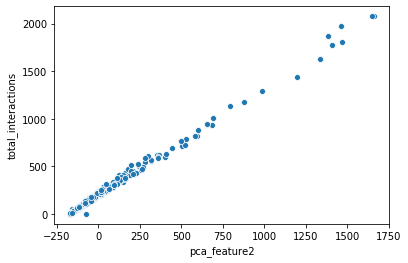

In [18]:
sns.scatterplot(data=df2, x='pca_feature2', y='total_interactions')
plt.show()

## Splitting the data 

In [19]:
Y = np.array(df2['total_interactions']).reshape(-1,1)
X = np.array(df2['pca_feature2']).reshape(-1,1)

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 99)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 400
The number of observations in test set is 100


## Metric

We'll be using MAE to evaluate the perfromance of the model.

In [21]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, Y)
    
    # Make predictions and evalute
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    
    
    # Plot
    plt.scatter(y_test, y_preds_test)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("Charges: true and predicted values")
    plt.show()
    
    
    print("R-squared of the model in the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model in the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))


# Modeling

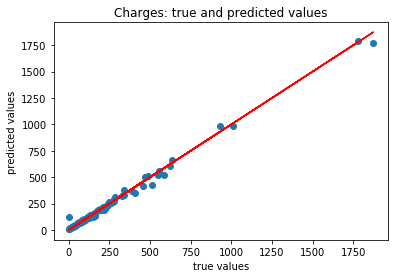

R-squared of the model in the training set is: 0.995872898700558
-----Test set statistics-----
R-squared of the model in the test set is: 0.9933145763397656
Mean absolute error of the prediction is: 13.383818202382033


In [22]:
# Linear Regression

lr = LinearRegression()
fit_and_evaluate(lr)



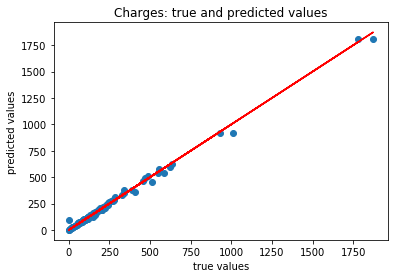

R-squared of the model in the training set is: 0.9930918759640263
-----Test set statistics-----
R-squared of the model in the test set is: 0.9952687940189648
Mean absolute error of the prediction is: 10.951999999999998


In [23]:
# KNN Regression

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
fit_and_evaluate(knn)



Both the models performed fairly well, capturing about 99% of the variance in the target variable in the training and testing set. However, it appears that the KNN regression is a better model than OLS regression for predicting the total amount of interaction a post will get. The KNN model MAE was 10.95 which is less than OLS model 13.38. 